In [4]:
# ! git clone https://github.com/CodeArchitecture/FinRL.git

In [5]:
# import os
# os.chdir('/kaggle/working/FinRL')
# print(os.getcwd())

In [6]:
# ! pip install -r requirements.txt

In [7]:
from IPython.display import clear_output
clear_output(wait=True)

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, get_baseline
import itertools
from datetime import timedelta 
from datetime import datetime
from finrl.config_tickers import DOW_30_TICKER, SSE_50_TICKER, HSI_50_TICKER
from finrl.main import clean_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR, INDICATORS

In [9]:
clean_and_make_directories([TRAINED_MODEL_DIR, RESULTS_DIR, os.path.join(RESULTS_DIR,'a2c'),
                            os.path.join(RESULTS_DIR,'ddpg'),os.path.join(RESULTS_DIR,'ppo'),
                            os.path.join(RESULTS_DIR,'td3'),os.path.join(RESULTS_DIR,'sac')])

In [10]:
TRAIN_START_DATE = '2012-01-01'
TRAIN_END_DATE = '2022-01-01'
TRADE_START_DATE = '2022-01-01'
TRADE_END_DATE = '2023-01-01'

TIMESTEPS = [100,100,100,100,100]
# TIMESTEPS = [20000,20000,20000,20000,20000]

# '^DJI','^SSE','^HSI'
# DOW_30_TICKER, SSE_50_TICKER, HSI_50_TICKER
DATA_NAME = 'DJIA'
PORTFOLIO = SSE_50_TICKER
BASELINES = '^SSE'

In [11]:
L=400
# download more date to compute tech indicator like macd
date = datetime.strptime(TRAIN_START_DATE, "%Y-%m-%d")
date = date - timedelta(days=L)
datetime.strftime(date, "%Y-%m-%d")
df = YahooDownloader(start_date = date,
                     end_date = TRADE_END_DATE,
                     ticker_list = PORTFOLIO).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
print(PORTFOLIO)

['600010.SS', '600690.SS', '600104.SS', '600031.SS', '600406.SS', '600309.SS', '600036.SS', '600048.SS', '601088.SS', '601628.SS', '600745.SS', '601919.SS', '600196.SS', '601899.SS', '601166.SS', '601857.SS', '600436.SS', '601633.SS', '601669.SS', '601012.SS', '603799.SS', '603986.SS', '603259.SS', '601066.SS', '688599.SS', '600030.SS', '600900.SS', '600028.SS', '600346.SS', '600111.SS', '600809.SS', '600585.SS', '600519.SS', '600887.SS', '600893.SS', '601398.SS', '601668.SS', '601688.SS', '600438.SS', '601288.SS', '600276.SS', '601888.SS', '601318.SS', '601225.SS', '603288.SS', '603501.SS', '601601.SS', '603260.SS', '601995.SS', '600905.SS']


In [13]:
df.shape

(128091, 8)

In [14]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-11-29,1.482142,1.492857,1.457142,1.436642,107509872,600010.SS,0
1,2010-11-29,6.276923,6.323076,6.253846,3.000211,43469587,600028.SS,0
2,2010-11-29,13.250000,13.340000,13.110000,10.143907,83091540,600030.SS,0
3,2010-11-29,14.720000,15.000000,14.573333,12.291307,122100142,600031.SS,0
4,2010-11-29,12.977993,13.144755,12.968183,8.412340,54638957,600036.SS,0


In [15]:
df.tic.value_counts()

600010.SS    2940
601628.SS    2940
601318.SS    2940
600028.SS    2940
601166.SS    2940
601857.SS    2940
600900.SS    2940
600887.SS    2940
600809.SS    2940
600745.SS    2940
600690.SS    2940
600585.SS    2940
600519.SS    2940
600438.SS    2940
600436.SS    2940
600406.SS    2940
600346.SS    2940
600309.SS    2940
600276.SS    2940
601919.SS    2940
600111.SS    2940
600104.SS    2940
600048.SS    2940
600036.SS    2940
600031.SS    2940
600030.SS    2940
601668.SS    2940
601888.SS    2937
601288.SS    2937
601601.SS    2937
601398.SS    2937
601088.SS    2937
600893.SS    2937
600196.SS    2937
601688.SS    2936
601899.SS    2936
601633.SS    2734
601669.SS    2725
601012.SS    2609
601225.SS    2172
603288.SS    2167
603799.SS    1927
603986.SS    1547
603501.SS    1378
603260.SS    1258
603259.SS    1132
601066.SS    1097
688599.SS     624
601995.SS     529
600905.SS     381
Name: tic, dtype: int64

In [16]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3043, 8)
Successfully added vix
Successfully added turbulence index


In [17]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [18]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-11-29,600010.SS,1.482142,1.492857,1.457142,1.436642,107509872.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,1.436642,1.436642,21.530001,0.0
1,2010-11-29,600028.SS,6.276923,6.323076,6.253846,3.000211,43469587.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,3.000211,3.000211,21.530001,0.0
2,2010-11-29,600030.SS,13.250000,13.340000,13.110000,10.143907,83091540.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,10.143907,10.143907,21.530001,0.0
3,2010-11-29,600031.SS,14.720000,15.000000,14.573333,12.291307,122100142.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,12.291307,12.291307,21.530001,0.0
4,2010-11-29,600036.SS,12.977993,13.144755,12.968183,8.412340,54638957.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,8.412340,8.412340,21.530001,0.0
5,2010-11-29,600048.SS,5.316239,5.320512,5.200854,3.425289,54670264.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,3.425289,3.425289,21.530001,0.0
6,2010-11-29,600104.SS,17.400000,17.490000,17.090000,9.948705,23192112.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,9.948705,9.948705,21.530001,0.0
7,2010-11-29,600111.SS,16.222221,16.315556,15.551111,14.794923,128942446.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,14.794923,14.794923,21.530001,0.0
8,2010-11-29,600276.SS,7.263152,7.378686,6.979677,6.948236,36135192.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,6.948236,6.948236,21.530001,0.0
9,2010-11-29,600309.SS,12.179487,12.307692,11.801282,8.588563,34613676.0,0.0,0.0,1.477884,1.350287,0.0,-66.666667,100.0,8.588563,8.588563,21.530001,0.0


In [19]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

63423
6264


In [20]:
train.head(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2012-01-04,600010.SS,1.482142,1.528571,1.460714,1.442186,188316668.0,2.0,-0.054544,1.558376,1.251630,39.975502,-14.879868,8.800546,1.471842,1.639170,22.219999,68.246114
0,2012-01-04,600028.SS,5.600000,5.723076,5.592307,2.781849,68663579.0,2.0,-0.007368,2.823374,2.614839,53.295579,98.635277,30.466259,2.726666,2.726225,22.219999,68.246114


In [21]:
train.tail(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2348,2021-12-31,601857.SS,4.90,4.93,4.880000,4.639749,74548057.0,4.0,-0.017700,4.775703,4.546317,47.179414,2.805989,5.265710,4.632504,4.860081,17.219999,15.203687
2348,2021-12-31,601919.SS,18.85,18.90,18.530001,14.876917,122998555.0,4.0,0.409524,15.574139,14.287152,53.370081,45.486249,6.607028,14.236681,13.438311,17.219999,15.203687


In [22]:
trade.head(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-04,600010.SS,2.80,2.83,2.77,2.768880,548999620.0,1.0,-0.019324,3.166256,2.66328,47.966898,-92.831012,2.788024,2.901535,2.808412,16.91,14.205658
0,2022-01-04,600028.SS,4.24,4.27,4.22,3.555848,133339718.0,1.0,0.013315,3.572980,3.47027,52.283090,93.700735,25.806045,3.496584,3.521903,16.91,14.205658


In [23]:
trade.tail(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
231,2022-12-29,601857.SS,5.03,5.03,4.96,4.96,124861888.0,3.0,-0.034474,5.295401,4.884599,45.412844,-103.717392,8.131087,5.100000,5.085333,21.440001,11.09466
231,2022-12-29,601919.SS,10.38,10.38,10.13,10.14,62167018.0,3.0,-0.026415,11.461552,10.193725,45.131707,-128.804775,41.007340,10.690923,10.216338,21.440001,11.09466


In [24]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [25]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 27, State Space: 271


In [26]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [27]:
env_train, _ = StockTradingEnv(df = train, **env_kwargs).get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [28]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [29]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

trained_a2c = agent.train_model(model=model_a2c, 
                             total_timesteps=TIMESTEPS[0]) if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


### Agent 2: DDPG

In [30]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

trained_ddpg = agent.train_model(model=model_ddpg, 
                             total_timesteps=TIMESTEPS[1]) if if_using_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


### Agent 3: PPO

In [31]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, 
                             total_timesteps=TIMESTEPS[2]) if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
-----------------------------------
| time/              |            |
|    fps             | 44         |
|    iterations      | 1          |
|    time_elapsed    | 46         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -5.1036663 |
-----------------------------------


### Agent 4: TD3

In [32]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

trained_td3 = agent.train_model(model=model_td3, 
                             total_timesteps=TIMESTEPS[3]) if if_using_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


### Agent 5: SAC

In [33]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

trained_sac = agent.train_model(model=model_sac, 
                             total_timesteps=TIMESTEPS[4]) if if_using_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


## In-sample Performance

In [34]:
insample_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)].drop_duplicates(subset=['date'])

count    2349.000000
mean       17.044593
std         6.879551
min         9.140000
25%        12.970000
50%        15.290000
75%        18.860001
max        82.690002
Name: vix, dtype: float64


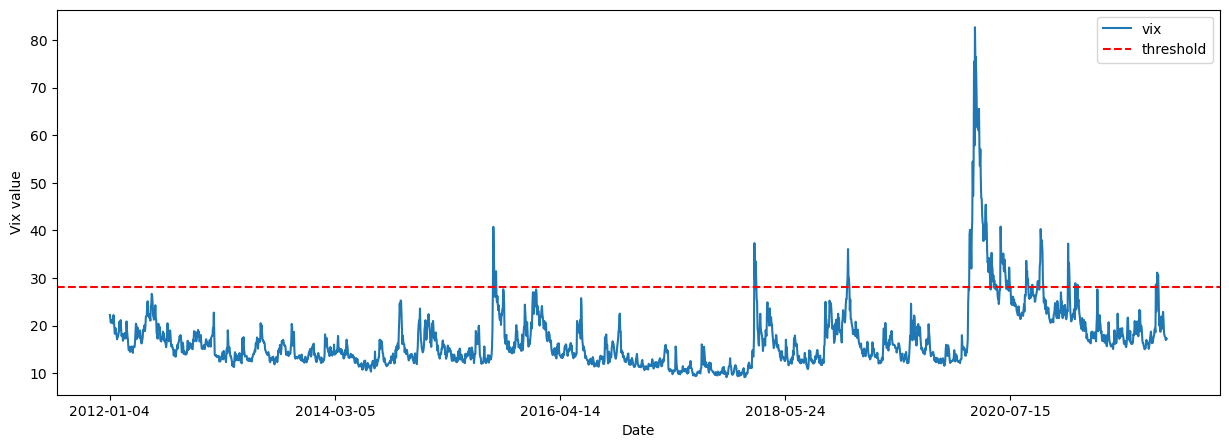

In [35]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/train_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/train_vix_describe.csv')

count    2349.000000
mean       36.691757
std        38.882705
min         2.820232
25%        16.896589
50%        27.017765
75%        44.378700
max      1092.940852
Name: turbulence, dtype: float64


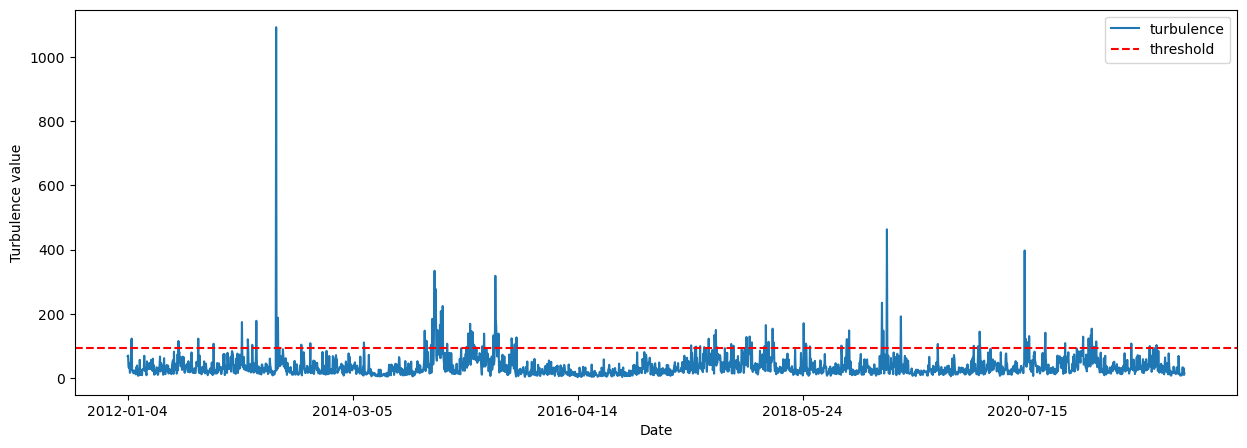

In [36]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/train_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/train_turbulence_describe.csv')

In [37]:
insample_risk_indicator = processed_full[(processed_full.date<TRADE_END_DATE) & (processed_full.date>=TRADE_START_DATE)].drop_duplicates(subset=['date'])

count    232.000000
mean      25.655216
std        4.203059
min       16.910000
25%       22.270000
50%       25.559999
75%       28.855000
max       36.450001
Name: vix, dtype: float64


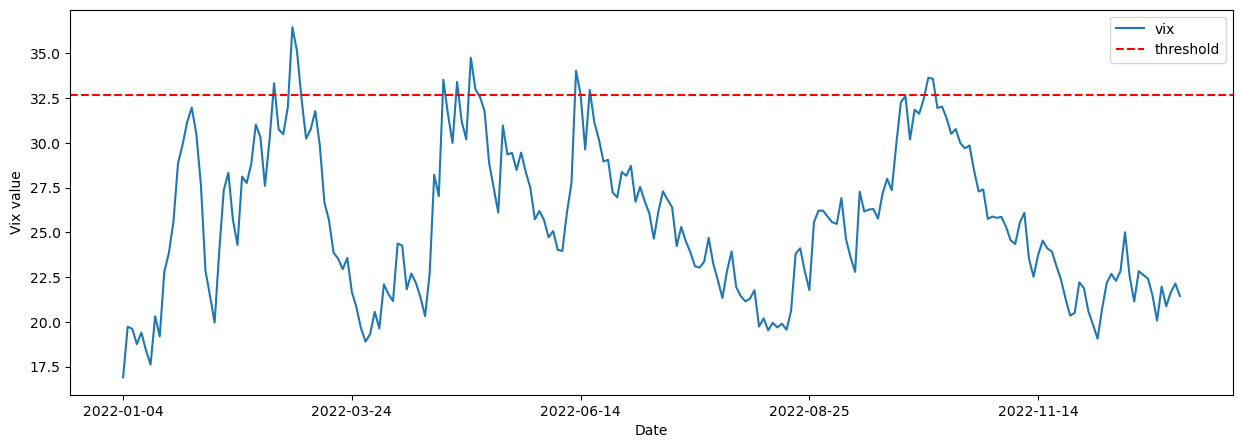

In [38]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/trade_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/trade_vix_describe.csv')

count    232.000000
mean      24.543555
std       16.928212
min        4.083410
25%       12.568743
50%       19.593473
75%       30.114302
max      113.450833
Name: turbulence, dtype: float64


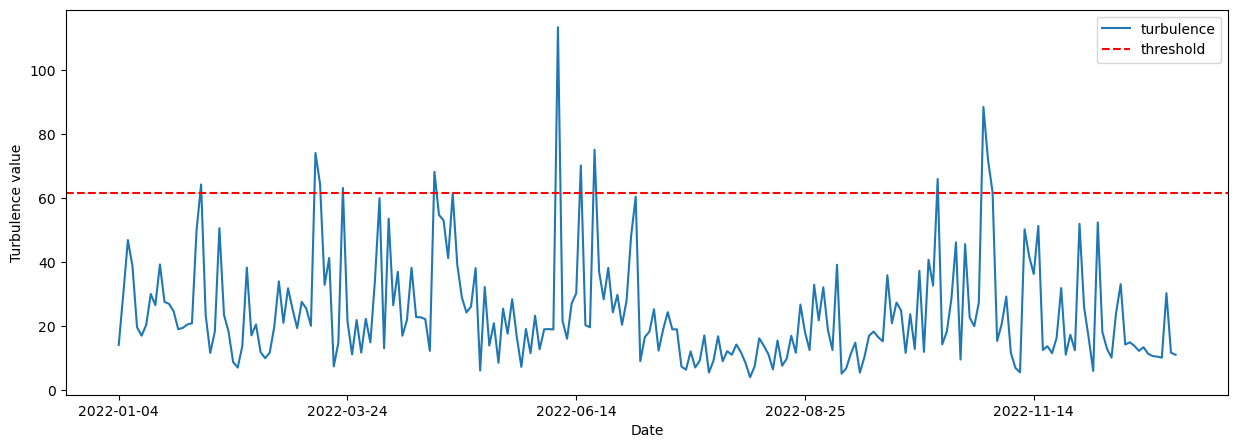

In [39]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/trade_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/trade_turbulence_describe.csv')

In [40]:
model_list = {'a2c':trained_a2c,'ddpg':trained_ddpg,'ppo':trained_ppo,'sac':trained_sac,'td3':trained_td3}
model_name_list = ['a2c','ddpg','ppo','sac','td3']
for i, model_name in enumerate(model_name_list):
    for j, vix_quantile in enumerate([0.8,0.85,0.9,0.95]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.vix.quantile(vix_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_vix{}'.format(model_name,int(vix_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_vix{}'.format(model_name,int(vix_quantile*100)))
    for j, turbulence_quantile in enumerate([0.8,0.85,0.9,0.95]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.turbulence.quantile(turbulence_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_turbulence{}'.format(model_name,int(turbulence_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_turbulence{}'.format(model_name,int(turbulence_quantile*100)))

In [44]:
BASELINES = '^SSE'
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(ticker=BASELINES, start = TRADE_START_DATE, end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = pd.read_csv('results/a2c/df_account_value_turbulence80')['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("results/df_{}.csv".format(DATA_NAME))

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^SSE: Period 'max' is invalid, must be one of ['1d', '5d']


ValueError: no data is fetched.

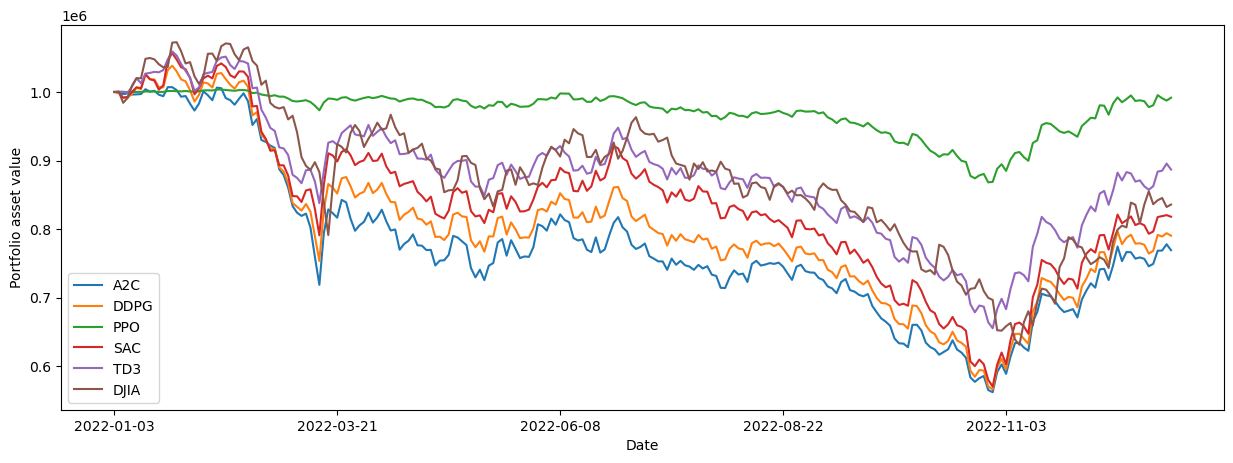

In [ ]:
%matplotlib inline
df1 = pd.read_csv('results/a2c/df_account_value_turbulence90',index_col=0)
df2 = pd.read_csv('results/ddpg/df_account_value_turbulence90',index_col=0)
df3 = pd.read_csv('results/ppo/df_account_value_turbulence90',index_col=0)
df4 = pd.read_csv('results/sac/df_account_value_turbulence90',index_col=0)
df5 = pd.read_csv('results/td3/df_account_value_turbulence90',index_col=0)
df6 = pd.read_csv('results/df_{}.csv'.format(DATA_NAME),index_col=0)

plt.rcParams["figure.figsize"] = (15,5)
df = pd.concat([df1,df2,df3,df4,df5,df6],axis=1)
df.columns=['A2C','DDPG','PPO','SAC','TD3', DATA_NAME]
fig = df.plot()
fig.set_xlabel('Date')
fig.set_ylabel('Portfolio asset value')
plt.legend()
fig.get_figure().savefig('results/backtest.png')

In [ ]:
import shutil
folder_name = 'results'
zip_file_name = 'results'
shutil.make_archive(zip_file_name, 'zip', folder_name)

'c:\\Users\\ThinkPad\\Desktop\\code\\FinRL\\results.zip'

In [ ]:
# pd.DataFrame(backtest_stats(account_value=df_account_value_a2c)).to_csv('results/a2c_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ddpg)).to_csv('results/ddpg_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_td3)).to_csv('results/td3_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ppo)).to_csv('results/ppo_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_sac)).to_csv('results/sac_perf.csv')